# About this notebook

## Version1
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- No weight initialization
- No categorical features are used

## Version2
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- Data normalization is used

## Version3
- PyTorch lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- no weight initialization
- categorical features are used
- No data normalization is used


# Library

In [16]:
import os
import random
from tqdm.auto import tqdm
import time
import wandb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau,
OneCycleLR)
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

DIR = 'model_weights/'
if not os.path.exists(DIR):
    os.mkdir(DIR)

device=("cuda" if torch.cuda.is_available() else "cpu")
VERSION=3

# Load data

In [2]:
data = pd.read_csv('~/Downloads/Beijing air quality/data/airquality_data.csv')
FEATURES_COLUMNS = [col for col in data.columns if col not in ['No', 'year', 'month', 'day', 'hour']]

# Configuration

In [3]:
class CFG:
    apex=False
    debug=False
    kaggle = False
    print_freq=500
    num_workers=1
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=60
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':5,
        'eta_min':1e-4,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=32 #64
    lr=1e-4
    weight_decay=1e-2
    gradient_accumulation_steps=1
    max_grad_norm=1000 # Gradient clipping to prevent exploding / vanishing gradient 
    target_size=1
    num_layers=3
    input_size=len(FEATURES_COLUMNS)
    hidden_size=100
    seq_length=48 # 48h
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    target_col="PM2.5"
    model_name="lstm_network"
    group = 'lstm'
    train=True
    seed=42
    
if CFG.debug:
    CFG.epochs=2
    data=data.sample(n=10000, random_state=CFG.seed).reset_index(drop=True).fillna(method="ffill")

# Data Preprocessing

### Train test split

In [4]:
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [5]:
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

### Data normalization

In [6]:
#scaler = MinMaxScaler()
#scaler = scaler.fit(train[FEATURES_COLUMNS])

In [7]:
#train = pd.DataFrame(np.concatenate((scaler.transform(train[FEATURES_COLUMNS]), train['PM2.5'].values.reshape(-1, 1)), axis=1),
#                     index=train.index,
#                     columns=FEATURES_COLUMNS+['PM2.5'])
#train = train.reset_index(drop=True)
#
#valid = pd.DataFrame(np.concatenate((scaler.transform(valid[FEATURES_COLUMNS]), valid['PM2.5'].values.reshape(-1, 1)), axis=1),
#                     index=valid.index,
#                     columns=FEATURES_COLUMNS+['PM2.5'])
#valid = valid.reset_index(drop=True)
#
#test = pd.DataFrame(np.concatenate((scaler.transform(test[FEATURES_COLUMNS]), test['PM2.5'].values.reshape(-1, 1)), axis=1),
#                     index=test.index,
#                     columns=FEATURES_COLUMNS+['PM2.5'])
#test = test.reset_index(drop=True)

# Utils

In [8]:
def get_score(y_true, y_pred):
    score = math.sqrt(mse(y_true, y_pred))
    return score

def init_logger(log_file=DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=45)


def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    
    sequences = []
    data_size = input_data.shape[0]
    for i in tqdm(range(data_size - sequence_length)):
        
        sequence = input_data[i: i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence[FEATURES_COLUMNS], label))
        
    return sequences

### Create sequences from  data

In [9]:
%%time
train_sequence = create_sequences(train, CFG.target_col, CFG.seq_length)
valid_sequence = create_sequences(valid, CFG.target_col, CFG.seq_length)
test_sequence = create_sequences(test, CFG.target_col, CFG.seq_length)

  0%|          | 0/325268 [00:00<?, ?it/s]

  0%|          | 0/36099 [00:00<?, ?it/s]

  0%|          | 0/40115 [00:00<?, ?it/s]

CPU times: user 3min 25s, sys: 5.37 s, total: 3min 31s
Wall time: 3min 26s


# Pytorch Dataset

In [10]:
class AirQualityDataset(Dataset):
    
    def __init__(self, sequences):
        
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        
        sequence, target = self.sequences[idx]
        
        return torch.tensor(sequence.to_numpy()).float(), torch.tensor(target).float()

In [11]:
train_dataset = AirQualityDataset(train_sequence)
sequence, label = train_dataset[0]
print(f'sequence shape: {sequence.shape}')
print(f'label shape: {label.shape}')

sequence shape: torch.Size([48, 13])
label shape: torch.Size([])


# W&B

In [12]:
if CFG.kaggle:
    
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_api = user_secrets.get_secret("wandb_key")

    wandb.login(key=wandb_api)

else:
    
    wandb.login()

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Baijing airquality prediction", 
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.group,
                 tags=[f'CFG.model_name_version{VERSION}'],
                 job_type="train")

wandb: Currently logged in as: djoe. Use `wandb login --relogin` to force relogin


# Model

In [13]:
class LSTM(nn.Module):

    def __init__(
                 self, 
                 target_size=CFG.target_size,
                 input_size=CFG.input_size, 
                 hidden_size=CFG.hidden_size,
                 num_layers=CFG.num_layers
                 ):
        
        super(LSTM, self).__init__()
        
        self.target_size = CFG.target_size
        self.num_layers = CFG.num_layers
        self.input_size = CFG.input_size
        self.hidden_size = CFG.hidden_size
        self.seq_length = CFG.seq_length
        
        self.lstm = nn.LSTM(
                            input_size=self.input_size, # Features of the sequence
                            hidden_size=self.hidden_size, # Hidden units for the lstm
                            num_layers=self.num_layers, # Number of layers
                            batch_first=True, # (batch, seq, features)
                            dropout=0.2,
                            bidirectional=True
                           )
        
        self.fc = nn.Linear(self.hidden_size, self.target_size)
        
        
    def forward(self, x):
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)
        
        h_out = h_out[-1]
        
        out = self.fc(h_out)
        
        return out

# Helper Functions

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (sequences, targets) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(sequences)
                loss = criterion(y_preds.squeeze(1), targets)
        else:
            y_preds = model(sequences)
            loss = criterion(y_preds.squeeze(1), targets)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if fold:
            
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
        else:
            
            wandb.log({"loss": losses.val,
                       "lr": scheduler.get_last_lr()[0]})
            
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    targets_list = []
    start = end = time.time()
    for step, (sequences, targets) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(sequences)
        preds.append(y_preds.detach().to('cpu').numpy())
        targets_list.append(targets.detach().to('cpu').numpy())
        
        loss = criterion(y_preds.squeeze(1), targets)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    targets = np.concatenate(targets_list)
    return losses.avg, predictions, targets

# ====================================================
# inference
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    forcasts = []
    targets_list = []
    for i, (sequences, targets) in enumerate(tk0):
        sequences = sequences.to(device).float()
        targets = targets.to(device).float()
        avg_forcasts = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(sequences)
            avg_forcasts.append(y_preds.detach().to("cpu").numpy())
        avg_forcasts = np.mean(avg_forcasts, axis=0)
        forcasts.append(avg_forcasts)
        targets_list.append(targets.detach().to("cpu").numpy())
    forcasts = np.concatenate(forcasts)
    targets = np.concatenate(targets_list)
    return forcasts, targets

# Train Loop

In [17]:
####################################################
############## Dataloader for pytorch ##############
####################################################

seed_torch(seed=45)
train_dataset = AirQualityDataset(train_sequence)

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.batch_size, 
                          shuffle=False, # Time series data
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)


valid_dataset = AirQualityDataset(valid_sequence)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


test_dataset = AirQualityDataset(test_sequence)

test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = LSTM()
model.to(device)
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = get_scheduler(optimizer)

# ====================================================
# loop
# ====================================================
criterion = nn.MSELoss()
best_loss = np.inf

for epoch in range(CFG.epochs):
        
    start_time = time.time()
    
    
    # train
    avg_loss = train_fn(None, train_loader, model, criterion, optimizer, epoch, scheduler, device)
    
    # eval
    avg_val_loss, valid_preds, valid_targets = valid_fn(valid_loader, model, criterion, device)
    
    

    
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    # scoring
    score = get_score(valid_targets, valid_preds)
    elapsed = time.time() - start_time
    
        
    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
    wandb.log({f" epoch": epoch+1, 
               f" avg_train_loss": avg_loss, 
               f" avg_val_loss": avg_val_loss,
               f" score": score
              })
    # Save best weights    
    if avg_val_loss < best_loss:
        LOGGER.info(f"Validation loss Improved ({best_loss} ---> {avg_val_loss})")
        best_loss = avg_val_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict(), 
                    'preds_loss': valid_preds,
                    'targets': valid_targets},
                    DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth')
        
# Inference
states = [torch.load(DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth', map_location=device)]
test_preds, test_targets = inference(model, states, test_loader, device)
LOGGER.info(f'RMSE score on validation set: {get_score(valid_targets, valid_preds)}')
LOGGER.info(f'RMSE score on test set: {get_score(test_targets, test_preds)}')

Epoch: [1][0/10164] Elapsed 0m 0s (remain 13m 46s) Loss: 5666.7520(5666.7520) Grad: 219.9418 LR: 0.000100  
Epoch: [1][500/10164] Elapsed 0m 4s (remain 1m 20s) Loss: 1193.7786(8211.6713) Grad: 399.4377 LR: 0.000100  
Epoch: [1][1000/10164] Elapsed 0m 8s (remain 1m 16s) Loss: 5650.9541(7159.5001) Grad: 1318.0226 LR: 0.000100  
Epoch: [1][1500/10164] Elapsed 0m 12s (remain 1m 11s) Loss: 23197.2754(6981.0903) Grad: 2542.0198 LR: 0.000100  
Epoch: [1][2000/10164] Elapsed 0m 16s (remain 1m 7s) Loss: 3091.0840(6417.7409) Grad: 886.7528 LR: 0.000100  
Epoch: [1][2500/10164] Elapsed 0m 20s (remain 1m 3s) Loss: 1193.4222(6337.2597) Grad: 523.6336 LR: 0.000100  
Epoch: [1][3000/10164] Elapsed 0m 24s (remain 0m 59s) Loss: 868.5580(6035.6824) Grad: 435.6853 LR: 0.000100  
Epoch: [1][3500/10164] Elapsed 0m 29s (remain 0m 55s) Loss: 719.7050(5905.2421) Grad: 374.6118 LR: 0.000100  
Epoch: [1][4000/10164] Elapsed 0m 33s (remain 0m 51s) Loss: 935.0078(5621.4305) Grad: 388.9656 LR: 0.000100  
Epoch: [1

Epoch 1 - avg_train_loss: 4485.0378  avg_val_loss: 3610.9378  time: 93s
Epoch 1 - Score: 60.0911
Validation loss Improved (inf ---> 3610.9378377755443)
Epoch 1 - Save Best Loss: 3610.9378 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 5341.6060(3610.9378) 
Epoch: [2][0/10164] Elapsed 0m 0s (remain 13m 40s) Loss: 1657.4465(1657.4465) Grad: 191.1300 LR: 0.000094  
Epoch: [2][500/10164] Elapsed 0m 4s (remain 1m 28s) Loss: 1467.5500(3833.6117) Grad: 522.4725 LR: 0.000094  
Epoch: [2][1000/10164] Elapsed 0m 9s (remain 1m 24s) Loss: 1772.4060(3497.9421) Grad: 4021.3381 LR: 0.000094  
Epoch: [2][1500/10164] Elapsed 0m 13s (remain 1m 18s) Loss: 14325.2578(3455.7351) Grad: 2560.1924 LR: 0.000094  
Epoch: [2][2000/10164] Elapsed 0m 18s (remain 1m 13s) Loss: 825.7393(3179.8549) Grad: 20480.8848 LR: 0.000094  
Epoch: [2][2500/10164] Elapsed 0m 22s (remain 1m 9s) Loss: 415.7662(3168.9941) Grad: 11450.5479 LR: 0.000094  
Epoch: [2][3000/10164] Elapsed 0m 27s (remain 1m 4s) Loss: 192.5244(3030.8472) Grad: 22123.0996 LR: 0.000094  
Epoch: [2][3500/10164] Elapsed 0m 31s (remain 1m 0s) Loss: 274.0841(3000.8883) Grad: 6779.3008 LR: 0.000094  
Epoch: [2][4000/10164] Elapsed 0m 36s (r

Epoch 2 - avg_train_loss: 2274.1568  avg_val_loss: 1643.0613  time: 95s
Epoch 2 - Score: 40.5347
Validation loss Improved (3610.9378377755443 ---> 1643.0612886599442)
Epoch 2 - Save Best Loss: 1643.0613 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1970.6289(1643.0613) 
Epoch: [3][0/10164] Elapsed 0m 0s (remain 13m 57s) Loss: 568.3794(568.3794) Grad: 52764.0547 LR: 0.000078  
Epoch: [3][500/10164] Elapsed 0m 4s (remain 1m 29s) Loss: 96.4484(1754.6896) Grad: 17997.2695 LR: 0.000078  
Epoch: [3][1000/10164] Elapsed 0m 9s (remain 1m 24s) Loss: 634.4654(1575.6342) Grad: 19145.9062 LR: 0.000078  
Epoch: [3][1500/10164] Elapsed 0m 13s (remain 1m 19s) Loss: 8528.5547(1608.2623) Grad: 1438.7677 LR: 0.000078  
Epoch: [3][2000/10164] Elapsed 0m 18s (remain 1m 14s) Loss: 84.2853(1499.9901) Grad: 11131.6104 LR: 0.000078  
Epoch: [3][2500/10164] Elapsed 0m 22s (remain 1m 9s) Loss: 128.4721(1519.1525) Grad: 51812.9688 LR: 0.000078  
Epoch: [3][3000/10164] Elapsed 0m 26s (remain 1m 4s) Loss: 54.4616(1468.6809) Grad: 2395.8464 LR: 0.000078  
Epoch: [3][3500/10164] Elapsed 0m 31s (remain 0m 59s) Loss: 142.2810(1477.8016) Grad: 24917.1758 LR: 0.000078  
Epoch: [3][4000/10164] Elapsed 0m 35s (rem

Epoch 3 - avg_train_loss: 1242.4827  avg_val_loss: 1095.1682  time: 90s
Epoch 3 - Score: 33.0933
Validation loss Improved (1643.0612886599442 ---> 1095.1682334971126)
Epoch 3 - Save Best Loss: 1095.1682 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 913.8478(1095.1682) 
Epoch: [4][0/10164] Elapsed 0m 0s (remain 13m 33s) Loss: 696.0013(696.0013) Grad: 101199.8516 LR: 0.000055  
Epoch: [4][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 167.6545(1134.1553) Grad: 16367.3770 LR: 0.000055  
Epoch: [4][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 472.8957(1037.1842) Grad: 31359.4238 LR: 0.000055  
Epoch: [4][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 6114.4941(1066.3505) Grad: 1539.0505 LR: 0.000055  
Epoch: [4][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 120.5552(1005.5898) Grad: 39509.4570 LR: 0.000055  
Epoch: [4][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 97.6196(1021.5151) Grad: 31981.8125 LR: 0.000055  
Epoch: [4][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 88.2593(992.3698) Grad: 23314.2070 LR: 0.000055  
Epoch: [4][3500/10164] Elapsed 0m 29s (remain 0m 57s) Loss: 106.8725(1006.7904) Grad: 12917.5732 LR: 0.000055  
Epoch: [4][4000/10164] Elapsed 0m 34s (rem

Epoch 4 - avg_train_loss: 900.3066  avg_val_loss: 885.2622  time: 90s
Epoch 4 - Score: 29.7534
Validation loss Improved (1095.1682334971126 ---> 885.2622035417093)
Epoch 4 - Save Best Loss: 885.2622 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 859.0991(885.2622) 
Epoch: [5][0/10164] Elapsed 0m 0s (remain 13m 55s) Loss: 574.2542(574.2542) Grad: 143272.2656 LR: 0.000033  
Epoch: [5][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 108.6759(905.5646) Grad: 20609.8223 LR: 0.000033  
Epoch: [5][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 426.5666(836.6117) Grad: 47903.3984 LR: 0.000033  
Epoch: [5][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 4872.1626(863.3075) Grad: 34191.6094 LR: 0.000033  
Epoch: [5][2000/10164] Elapsed 0m 16s (remain 1m 8s) Loss: 140.3358(818.6615) Grad: 49268.2383 LR: 0.000033  
Epoch: [5][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 53.0941(832.6634) Grad: 14453.8506 LR: 0.000033  
Epoch: [5][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 88.6014(810.4349) Grad: 27694.0918 LR: 0.000033  
Epoch: [5][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 136.1015(825.9011) Grad: 11249.3887 LR: 0.000033  
Epoch: [5][4000/10164] Elapsed 0m 33s (remain 0m

Epoch 5 - avg_train_loss: 764.8574  avg_val_loss: 776.9082  time: 90s
Epoch 5 - Score: 27.8731
Validation loss Improved (885.2622035417093 ---> 776.908179184734)
Epoch 5 - Save Best Loss: 776.9082 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1007.8358(776.9082) 
Epoch: [6][0/10164] Elapsed 0m 0s (remain 13m 21s) Loss: 565.0691(565.0691) Grad: 104461.4141 LR: 0.000016  
Epoch: [6][500/10164] Elapsed 0m 4s (remain 1m 21s) Loss: 89.5110(816.9009) Grad: 14370.9717 LR: 0.000016  
Epoch: [6][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 470.9335(756.9542) Grad: 52155.8047 LR: 0.000016  
Epoch: [6][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 4427.4248(779.9598) Grad: 60748.8164 LR: 0.000016  
Epoch: [6][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 81.8037(741.7066) Grad: 37503.7422 LR: 0.000016  
Epoch: [6][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 52.0143(753.8183) Grad: 17626.6719 LR: 0.000016  
Epoch: [6][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 69.9145(734.4842) Grad: 6610.0703 LR: 0.000016  
Epoch: [6][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 111.6334(750.7575) Grad: 11517.6660 LR: 0.000016  
Epoch: [6][4000/10164] Elapsed 0m 34s (remain 0m 

Epoch 6 - avg_train_loss: 708.1242  avg_val_loss: 716.0943  time: 91s
Epoch 6 - Score: 26.7599
Validation loss Improved (776.908179184734 ---> 716.0943048048615)
Epoch 6 - Save Best Loss: 716.0943 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1486.0311(716.0943) 
Epoch: [7][0/10164] Elapsed 0m 0s (remain 13m 34s) Loss: 443.0964(443.0964) Grad: 75475.1406 LR: 0.000010  
Epoch: [7][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 79.2510(774.0999) Grad: 9949.4023 LR: 0.000010  
Epoch: [7][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 468.7809(720.6957) Grad: 57285.6250 LR: 0.000010  
Epoch: [7][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 4166.2935(743.2137) Grad: 43644.6445 LR: 0.000010  
Epoch: [7][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 55.7016(708.4340) Grad: 11819.0811 LR: 0.000010  
Epoch: [7][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 69.3881(719.9995) Grad: 28702.2578 LR: 0.000010  
Epoch: [7][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 68.4752(701.3971) Grad: 6357.4629 LR: 0.000010  
Epoch: [7][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 103.8347(717.1989) Grad: 8219.2471 LR: 0.000010  
Epoch: [7][4000/10164] Elapsed 0m 34s (remain 0m 52s)

Epoch 7 - avg_train_loss: 680.0437  avg_val_loss: 691.3729  time: 90s
Epoch 7 - Score: 26.2940
Validation loss Improved (716.0943048048615 ---> 691.3728615763894)
Epoch 7 - Save Best Loss: 691.3729 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1541.2295(691.3729) 
Epoch: [8][0/10164] Elapsed 0m 0s (remain 13m 37s) Loss: 414.6425(414.6425) Grad: 80391.3984 LR: 0.000016  
Epoch: [8][500/10164] Elapsed 0m 4s (remain 1m 21s) Loss: 118.3910(749.7746) Grad: 16377.0684 LR: 0.000016  
Epoch: [8][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 405.7007(697.1225) Grad: 42357.3242 LR: 0.000016  
Epoch: [8][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 4028.6086(718.2662) Grad: 23549.4473 LR: 0.000016  
Epoch: [8][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 74.5370(686.5705) Grad: 18577.2520 LR: 0.000016  
Epoch: [8][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 68.4357(696.5143) Grad: 43906.2695 LR: 0.000016  
Epoch: [8][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 43.2946(678.2794) Grad: 4161.3130 LR: 0.000016  
Epoch: [8][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 92.2855(693.2141) Grad: 7117.9443 LR: 0.000016  
Epoch: [8][4000/10164] Elapsed 0m 33s (remain 0m 52s

Epoch 8 - avg_train_loss: 654.8920  avg_val_loss: 660.9274  time: 90s
Epoch 8 - Score: 25.7085
Validation loss Improved (691.3728615763894 ---> 660.9274019528606)
Epoch 8 - Save Best Loss: 660.9274 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1511.3228(660.9274) 
Epoch: [9][0/10164] Elapsed 0m 0s (remain 18m 56s) Loss: 463.8806(463.8806) Grad: 97772.8203 LR: 0.000033  
Epoch: [9][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 106.3960(717.3681) Grad: 24228.3438 LR: 0.000033  
Epoch: [9][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 438.9507(668.3732) Grad: 35056.1562 LR: 0.000033  
Epoch: [9][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 3743.6436(687.6674) Grad: 19293.3672 LR: 0.000033  
Epoch: [9][2000/10164] Elapsed 0m 16s (remain 1m 8s) Loss: 63.2268(656.7215) Grad: 28026.6973 LR: 0.000033  
Epoch: [9][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 30.8912(665.2549) Grad: 17120.6445 LR: 0.000033  
Epoch: [9][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 46.2309(647.2113) Grad: 7845.3979 LR: 0.000033  
Epoch: [9][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 117.5652(660.7891) Grad: 6104.9390 LR: 0.000033  
Epoch: [9][4000/10164] Elapsed 0m 33s (remain 0m 52

Epoch 9 - avg_train_loss: 617.3401  avg_val_loss: 624.1649  time: 90s
Epoch 9 - Score: 24.9833
Validation loss Improved (660.9274019528606 ---> 624.1648703744502)
Epoch 9 - Save Best Loss: 624.1649 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1232.9540(624.1649) 
Epoch: [10][0/10164] Elapsed 0m 0s (remain 13m 17s) Loss: 323.6395(323.6395) Grad: 47004.7852 LR: 0.000055  
Epoch: [10][500/10164] Elapsed 0m 4s (remain 1m 21s) Loss: 142.4480(658.1404) Grad: 44620.1914 LR: 0.000055  
Epoch: [10][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 352.9122(618.0151) Grad: 43643.4609 LR: 0.000055  
Epoch: [10][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 3356.6750(633.6616) Grad: 61482.2578 LR: 0.000055  
Epoch: [10][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 52.1702(607.0153) Grad: 6167.6528 LR: 0.000055  
Epoch: [10][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 72.4094(613.9199) Grad: 20230.0664 LR: 0.000055  
Epoch: [10][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 68.0407(596.6910) Grad: 15281.5391 LR: 0.000055  
Epoch: [10][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 125.1399(608.3403) Grad: 13800.9463 LR: 0.000055  
Epoch: [10][4000/10164] Elapsed 0m 33s (re

Epoch 10 - avg_train_loss: 564.3039  avg_val_loss: 602.2709  time: 90s
Epoch 10 - Score: 24.5412
Validation loss Improved (624.1648703744502 ---> 602.2709482649977)
Epoch 10 - Save Best Loss: 602.2709 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1012.2070(602.2709) 
Epoch: [11][0/10164] Elapsed 0m 0s (remain 13m 11s) Loss: 547.5485(547.5485) Grad: 103625.2734 LR: 0.000078  
Epoch: [11][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 136.5419(595.1458) Grad: 46753.6992 LR: 0.000078  
Epoch: [11][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 339.1212(559.6506) Grad: 31603.8945 LR: 0.000078  
Epoch: [11][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 2909.2500(573.0610) Grad: 95981.0078 LR: 0.000078  
Epoch: [11][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 73.5220(551.5576) Grad: 15364.3857 LR: 0.000078  
Epoch: [11][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 43.4473(556.0532) Grad: 22666.1445 LR: 0.000078  
Epoch: [11][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 82.9510(540.0862) Grad: 10579.2822 LR: 0.000078  
Epoch: [11][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 124.6727(549.7927) Grad: 10196.7139 LR: 0.000078  
Epoch: [11][4000/10164] Elapsed 0m 34s 

Epoch 11 - avg_train_loss: 518.9661  avg_val_loss: 634.3179  time: 90s
Epoch 11 - Score: 25.1857


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 888.4169(634.3179) 
Epoch: [12][0/10164] Elapsed 0m 0s (remain 13m 28s) Loss: 492.3144(492.3144) Grad: 122152.5625 LR: 0.000094  
Epoch: [12][500/10164] Elapsed 0m 4s (remain 1m 26s) Loss: 133.0464(547.4528) Grad: 21374.4961 LR: 0.000094  
Epoch: [12][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 395.8583(517.1460) Grad: 40454.4375 LR: 0.000094  
Epoch: [12][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 2604.4998(527.3530) Grad: 56734.5625 LR: 0.000094  
Epoch: [12][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 102.0585(511.0607) Grad: 48569.1758 LR: 0.000094  
Epoch: [12][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 48.5753(514.3035) Grad: 61089.0000 LR: 0.000094  
Epoch: [12][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 66.1216(499.2648) Grad: 10062.2314 LR: 0.000094  
Epoch: [12][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 112.0603(508.8380) Grad: 10243.7119 LR: 0.000094  
Epoch: [12][4000/10164] Elapsed 0m 34s 

Epoch 12 - avg_train_loss: 472.3589  avg_val_loss: 545.3641  time: 91s
Epoch 12 - Score: 23.3530
Validation loss Improved (602.2709482649977 ---> 545.3640622126534)
Epoch 12 - Save Best Loss: 545.3641 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 959.2753(545.3641) 
Epoch: [13][0/10164] Elapsed 0m 0s (remain 13m 11s) Loss: 436.0977(436.0977) Grad: 89065.0312 LR: 0.000100  
Epoch: [13][500/10164] Elapsed 0m 4s (remain 1m 21s) Loss: 86.1112(489.8997) Grad: 11139.7148 LR: 0.000100  
Epoch: [13][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 399.7372(463.9858) Grad: 54342.1289 LR: 0.000100  
Epoch: [13][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 2136.7170(471.3767) Grad: 31705.8223 LR: 0.000100  
Epoch: [13][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 75.0290(458.5846) Grad: 31921.0586 LR: 0.000100  
Epoch: [13][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 45.5842(459.2761) Grad: 15659.6787 LR: 0.000100  
Epoch: [13][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 59.0033(445.3076) Grad: 7280.1348 LR: 0.000100  
Epoch: [13][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 113.7251(455.6932) Grad: 12710.2734 LR: 0.000100  
Epoch: [13][4000/10164] Elapsed 0m 34s (rema

Epoch 13 - avg_train_loss: 424.4895  avg_val_loss: 526.2889  time: 90s
Epoch 13 - Score: 22.9410
Validation loss Improved (545.3640622126534 ---> 526.2888786596798)
Epoch 13 - Save Best Loss: 526.2889 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1011.3420(526.2889) 
Epoch: [14][0/10164] Elapsed 0m 0s (remain 13m 33s) Loss: 530.4269(530.4269) Grad: 161958.4844 LR: 0.000094  
Epoch: [14][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 91.7901(438.8694) Grad: 8810.3408 LR: 0.000094  
Epoch: [14][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 388.8921(417.6057) Grad: 65220.9570 LR: 0.000094  
Epoch: [14][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 1717.9104(425.4959) Grad: 33914.4375 LR: 0.000094  
Epoch: [14][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 76.6090(418.5075) Grad: 9420.5254 LR: 0.000094  
Epoch: [14][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 68.9512(418.7901) Grad: 58030.9648 LR: 0.000094  
Epoch: [14][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 62.5862(405.1867) Grad: 7613.2549 LR: 0.000094  
Epoch: [14][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 119.3447(414.8596) Grad: 18970.3438 LR: 0.000094  
Epoch: [14][4000/10164] Elapsed 0m 34s (rema

Epoch 14 - avg_train_loss: 390.4766  avg_val_loss: 493.8622  time: 91s
Epoch 14 - Score: 22.2230
Validation loss Improved (526.2888786596798 ---> 493.8622454249062)
Epoch 14 - Save Best Loss: 493.8622 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 880.6682(493.8622) 
Epoch: [15][0/10164] Elapsed 0m 0s (remain 13m 20s) Loss: 402.6425(402.6425) Grad: 39619.7891 LR: 0.000078  
Epoch: [15][500/10164] Elapsed 0m 4s (remain 1m 28s) Loss: 99.9635(413.7432) Grad: 14955.2295 LR: 0.000078  
Epoch: [15][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 381.1761(395.2884) Grad: 73172.4453 LR: 0.000078  
Epoch: [15][1500/10164] Elapsed 0m 13s (remain 1m 16s) Loss: 1440.2382(400.9174) Grad: 45351.0898 LR: 0.000078  
Epoch: [15][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 58.8074(393.8980) Grad: 6876.0117 LR: 0.000078  
Epoch: [15][2500/10164] Elapsed 0m 22s (remain 1m 8s) Loss: 33.1357(392.5138) Grad: 16081.3525 LR: 0.000078  
Epoch: [15][3000/10164] Elapsed 0m 26s (remain 1m 4s) Loss: 56.7088(380.2162) Grad: 7353.7310 LR: 0.000078  
Epoch: [15][3500/10164] Elapsed 0m 31s (remain 0m 59s) Loss: 126.1424(389.0299) Grad: 8090.6260 LR: 0.000078  
Epoch: [15][4000/10164] Elapsed 0m 35s (remai

Epoch 15 - avg_train_loss: 368.0299  avg_val_loss: 472.4685  time: 92s
Epoch 15 - Score: 21.7363
Validation loss Improved (493.8622454249062 ---> 472.4684971330925)
Epoch 15 - Save Best Loss: 472.4685 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1008.3973(472.4685) 
Epoch: [16][0/10164] Elapsed 0m 0s (remain 13m 20s) Loss: 384.5042(384.5042) Grad: 57769.0352 LR: 0.000055  
Epoch: [16][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 90.4985(393.6697) Grad: 16283.0684 LR: 0.000055  
Epoch: [16][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 428.5922(375.6271) Grad: 50694.6172 LR: 0.000055  
Epoch: [16][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 1461.9946(382.1181) Grad: 32270.1230 LR: 0.000055  
Epoch: [16][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 67.7328(376.8650) Grad: 30237.6641 LR: 0.000055  
Epoch: [16][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 46.5136(374.3921) Grad: 37293.9336 LR: 0.000055  
Epoch: [16][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 98.4741(362.8023) Grad: 27911.5059 LR: 0.000055  
Epoch: [16][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 112.3038(372.0743) Grad: 6128.9893 LR: 0.000055  
Epoch: [16][4000/10164] Elapsed 0m 34s (re

Epoch 16 - avg_train_loss: 352.4172  avg_val_loss: 419.9780  time: 91s
Epoch 16 - Score: 20.4934
Validation loss Improved (472.4684971330925 ---> 419.9780480649987)
Epoch 16 - Save Best Loss: 419.9780 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1189.7271(419.9780) 
Epoch: [17][0/10164] Elapsed 0m 0s (remain 13m 19s) Loss: 392.5846(392.5846) Grad: 53431.6211 LR: 0.000033  
Epoch: [17][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 93.9907(379.8647) Grad: 10964.6318 LR: 0.000033  
Epoch: [17][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 404.6862(363.9316) Grad: 45357.0586 LR: 0.000033  
Epoch: [17][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 1293.1738(369.0390) Grad: 113559.4453 LR: 0.000033  
Epoch: [17][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 58.0174(364.4544) Grad: 22427.8262 LR: 0.000033  
Epoch: [17][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 36.4341(362.4425) Grad: 31346.9824 LR: 0.000033  
Epoch: [17][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 78.0143(350.7134) Grad: 23243.5391 LR: 0.000033  
Epoch: [17][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 119.0822(360.3535) Grad: 17139.0859 LR: 0.000033  
Epoch: [17][4000/10164] Elapsed 0m 34s (r

Epoch 17 - avg_train_loss: 341.3845  avg_val_loss: 371.6201  time: 91s
Epoch 17 - Score: 19.2775
Validation loss Improved (419.9780480649987 ---> 371.62008279044693)
Epoch 17 - Save Best Loss: 371.6201 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1375.8511(371.6201) 
Epoch: [18][0/10164] Elapsed 0m 0s (remain 13m 59s) Loss: 363.7701(363.7701) Grad: 26408.1523 LR: 0.000016  
Epoch: [18][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 73.1480(372.0603) Grad: 8377.4551 LR: 0.000016  
Epoch: [18][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 449.7027(356.9417) Grad: 45012.7852 LR: 0.000016  
Epoch: [18][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 1147.0018(361.2387) Grad: 175569.4219 LR: 0.000016  
Epoch: [18][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 56.1767(357.9128) Grad: 17537.9688 LR: 0.000016  
Epoch: [18][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 79.4172(354.6075) Grad: 71207.9531 LR: 0.000016  
Epoch: [18][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 53.3690(343.3686) Grad: 8769.7275 LR: 0.000016  
Epoch: [18][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 123.9542(353.1565) Grad: 16840.6328 LR: 0.000016  
Epoch: [18][4000/10164] Elapsed 0m 34s (rem

Epoch 18 - avg_train_loss: 334.9630  avg_val_loss: 339.5615  time: 91s
Epoch 18 - Score: 18.4272
Validation loss Improved (371.62008279044693 ---> 339.5615465626029)
Epoch 18 - Save Best Loss: 339.5615 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1608.8259(339.5615) 
Epoch: [19][0/10164] Elapsed 0m 0s (remain 14m 0s) Loss: 313.4641(313.4641) Grad: 43698.2852 LR: 0.000010  
Epoch: [19][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 74.8307(368.0368) Grad: 12914.6055 LR: 0.000010  
Epoch: [19][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 475.3500(352.1935) Grad: 45233.0742 LR: 0.000010  
Epoch: [19][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 1181.9938(356.7262) Grad: 85544.2031 LR: 0.000010  
Epoch: [19][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 51.5345(353.2782) Grad: 27911.4785 LR: 0.000010  
Epoch: [19][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 72.5409(350.7326) Grad: 77578.1094 LR: 0.000010  
Epoch: [19][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 51.7730(339.5029) Grad: 3510.9143 LR: 0.000010  
Epoch: [19][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 104.0547(348.5988) Grad: 10540.6025 LR: 0.000010  
Epoch: [19][4000/10164] Elapsed 0m 34s (rema

Epoch 19 - avg_train_loss: 331.1715  avg_val_loss: 334.5272  time: 90s
Epoch 19 - Score: 18.2901
Validation loss Improved (339.5615465626029 ---> 334.52719352707584)
Epoch 19 - Save Best Loss: 334.5272 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1561.0696(334.5272) 
Epoch: [20][0/10164] Elapsed 0m 0s (remain 13m 20s) Loss: 331.9686(331.9686) Grad: 34240.0430 LR: 0.000016  
Epoch: [20][500/10164] Elapsed 0m 4s (remain 1m 27s) Loss: 78.3014(362.2435) Grad: 18244.1816 LR: 0.000016  
Epoch: [20][1000/10164] Elapsed 0m 9s (remain 1m 22s) Loss: 434.9720(347.4210) Grad: 43159.6133 LR: 0.000016  
Epoch: [20][1500/10164] Elapsed 0m 13s (remain 1m 17s) Loss: 1146.8474(352.0941) Grad: 82850.5859 LR: 0.000016  
Epoch: [20][2000/10164] Elapsed 0m 17s (remain 1m 12s) Loss: 62.1500(348.8458) Grad: 44032.5508 LR: 0.000016  
Epoch: [20][2500/10164] Elapsed 0m 22s (remain 1m 7s) Loss: 61.9715(345.7845) Grad: 82248.5859 LR: 0.000016  
Epoch: [20][3000/10164] Elapsed 0m 26s (remain 1m 3s) Loss: 53.7663(334.7624) Grad: 10837.5186 LR: 0.000016  
Epoch: [20][3500/10164] Elapsed 0m 31s (remain 0m 59s) Loss: 112.4816(344.4927) Grad: 14799.6201 LR: 0.000016  
Epoch: [20][4000/10164] Elapsed 0m 35s (r

Epoch 20 - avg_train_loss: 328.0229  avg_val_loss: 333.4188  time: 92s
Epoch 20 - Score: 18.2598
Validation loss Improved (334.52719352707584 ---> 333.41877066426974)
Epoch 20 - Save Best Loss: 333.4188 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1581.6736(333.4188) 
Epoch: [21][0/10164] Elapsed 0m 0s (remain 13m 35s) Loss: 394.2377(394.2377) Grad: 49608.5508 LR: 0.000033  
Epoch: [21][500/10164] Elapsed 0m 4s (remain 1m 27s) Loss: 65.1646(361.1715) Grad: 9576.6934 LR: 0.000033  
Epoch: [21][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 383.7725(344.3892) Grad: 36478.5547 LR: 0.000033  
Epoch: [21][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 1100.9640(350.2295) Grad: 143991.3750 LR: 0.000033  
Epoch: [21][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 77.9070(347.7606) Grad: 47916.0469 LR: 0.000033  
Epoch: [21][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 45.6141(345.6835) Grad: 44156.4727 LR: 0.000033  
Epoch: [21][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 69.7824(334.4429) Grad: 19779.3633 LR: 0.000033  
Epoch: [21][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 117.9736(343.8814) Grad: 6508.8174 LR: 0.000033  
Epoch: [21][4000/10164] Elapsed 0m 34s (re

Epoch 21 - avg_train_loss: 326.8233  avg_val_loss: 336.7532  time: 91s
Epoch 21 - Score: 18.3508


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1351.1743(336.7532) 
Epoch: [22][0/10164] Elapsed 0m 0s (remain 13m 33s) Loss: 352.9007(352.9007) Grad: 35136.7734 LR: 0.000055  
Epoch: [22][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 69.1114(359.6082) Grad: 13410.8779 LR: 0.000055  
Epoch: [22][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 406.0479(343.8485) Grad: 35504.5312 LR: 0.000055  
Epoch: [22][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 1066.1254(348.1698) Grad: 296928.2500 LR: 0.000055  
Epoch: [22][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 59.5860(345.7283) Grad: 18906.2051 LR: 0.000055  
Epoch: [22][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 36.6886(343.7061) Grad: 43035.8555 LR: 0.000055  
Epoch: [22][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 68.1756(332.2943) Grad: 21776.5488 LR: 0.000055  
Epoch: [22][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 111.4087(341.3165) Grad: 11691.2930 LR: 0.000055  
Epoch: [22][4000/10164] Elapsed 0m 34s (r

Epoch 22 - avg_train_loss: 323.2459  avg_val_loss: 349.9497  time: 90s
Epoch 22 - Score: 18.7069


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1244.4851(349.9497) 
Epoch: [23][0/10164] Elapsed 0m 0s (remain 13m 29s) Loss: 354.2588(354.2588) Grad: 35265.6914 LR: 0.000078  
Epoch: [23][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 88.1991(357.7761) Grad: 25589.5020 LR: 0.000078  
Epoch: [23][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 403.1099(340.0555) Grad: 44614.5234 LR: 0.000078  
Epoch: [23][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 989.4171(344.3041) Grad: 135627.3281 LR: 0.000078  
Epoch: [23][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 70.3478(342.1426) Grad: 27233.6953 LR: 0.000078  
Epoch: [23][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 63.5916(339.5988) Grad: 76478.7344 LR: 0.000078  
Epoch: [23][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 62.9439(328.5080) Grad: 9729.8506 LR: 0.000078  
Epoch: [23][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 118.6493(337.4092) Grad: 10645.2383 LR: 0.000078  
Epoch: [23][4000/10164] Elapsed 0m 34s (re

Epoch 23 - avg_train_loss: 322.3056  avg_val_loss: 381.1362  time: 92s
Epoch 23 - Score: 19.5227


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1052.7294(381.1362) 
Epoch: [24][0/10164] Elapsed 0m 0s (remain 13m 25s) Loss: 382.5036(382.5036) Grad: 59546.9766 LR: 0.000094  
Epoch: [24][500/10164] Elapsed 0m 4s (remain 1m 25s) Loss: 119.1895(349.8408) Grad: 37004.7305 LR: 0.000094  
Epoch: [24][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 367.7458(333.8439) Grad: 42551.2539 LR: 0.000094  
Epoch: [24][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 932.5940(341.2938) Grad: 58925.1250 LR: 0.000094  
Epoch: [24][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 67.5748(338.9858) Grad: 17859.0078 LR: 0.000094  
Epoch: [24][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 31.7431(336.3647) Grad: 13936.0703 LR: 0.000094  
Epoch: [24][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 62.8910(324.9619) Grad: 17058.8867 LR: 0.000094  
Epoch: [24][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 124.5515(334.0301) Grad: 15689.9609 LR: 0.000094  
Epoch: [24][4000/10164] Elapsed 0m 34s (re

Epoch 24 - avg_train_loss: 318.3962  avg_val_loss: 364.8735  time: 90s
Epoch 24 - Score: 19.1017


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1218.6670(364.8735) 
Epoch: [25][0/10164] Elapsed 0m 0s (remain 13m 22s) Loss: 304.1188(304.1188) Grad: 33300.4531 LR: 0.000100  
Epoch: [25][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 110.8010(348.4423) Grad: 32807.7930 LR: 0.000100  
Epoch: [25][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 393.5262(331.5744) Grad: 50143.8750 LR: 0.000100  
Epoch: [25][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 847.6089(336.1037) Grad: 55192.8984 LR: 0.000100  
Epoch: [25][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 80.3736(335.2597) Grad: 27029.2598 LR: 0.000100  
Epoch: [25][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 52.4718(332.9814) Grad: 39110.8359 LR: 0.000100  
Epoch: [25][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 72.7426(321.3801) Grad: 18105.7324 LR: 0.000100  
Epoch: [25][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 133.6149(329.7147) Grad: 28454.4023 LR: 0.000100  
Epoch: [25][4000/10164] Elapsed 0m 34s (re

Epoch 25 - avg_train_loss: 316.0499  avg_val_loss: 426.3058  time: 91s
Epoch 25 - Score: 20.6472


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 953.3405(426.3058) 
Epoch: [26][0/10164] Elapsed 0m 0s (remain 13m 25s) Loss: 337.1851(337.1851) Grad: 44940.5898 LR: 0.000094  
Epoch: [26][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 83.5504(342.3945) Grad: 16798.4688 LR: 0.000094  
Epoch: [26][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 389.3309(325.2402) Grad: 33745.9062 LR: 0.000094  
Epoch: [26][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 739.8752(330.0375) Grad: 68119.2031 LR: 0.000094  
Epoch: [26][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 52.6994(328.6996) Grad: 17433.1855 LR: 0.000094  
Epoch: [26][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 55.7199(326.9336) Grad: 44797.5430 LR: 0.000094  
Epoch: [26][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 54.4446(315.2220) Grad: 8369.3330 LR: 0.000094  
Epoch: [26][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 122.8825(323.2898) Grad: 8883.6367 LR: 0.000094  
Epoch: [26][4000/10164] Elapsed 0m 34s (remai

Epoch 26 - avg_train_loss: 307.1334  avg_val_loss: 356.4617  time: 90s
Epoch 26 - Score: 18.8802


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1227.2107(356.4617) 
Epoch: [27][0/10164] Elapsed 0m 0s (remain 13m 34s) Loss: 282.1935(282.1935) Grad: 71580.9609 LR: 0.000078  
Epoch: [27][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 70.9299(327.6966) Grad: 10878.6357 LR: 0.000078  
Epoch: [27][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 457.7928(314.5432) Grad: 39318.2383 LR: 0.000078  
Epoch: [27][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 694.1139(319.7974) Grad: 123484.3750 LR: 0.000078  
Epoch: [27][2000/10164] Elapsed 0m 16s (remain 1m 8s) Loss: 45.6951(319.4085) Grad: 13162.3115 LR: 0.000078  
Epoch: [27][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 31.8791(316.1992) Grad: 17689.4824 LR: 0.000078  
Epoch: [27][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 72.4863(305.1169) Grad: 18017.3105 LR: 0.000078  
Epoch: [27][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 120.5952(313.4344) Grad: 9920.9463 LR: 0.000078  
Epoch: [27][4000/10164] Elapsed 0m 33s (rem

Epoch 27 - avg_train_loss: 299.5539  avg_val_loss: 348.3657  time: 91s
Epoch 27 - Score: 18.6646


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1075.9211(348.3657) 
Epoch: [28][0/10164] Elapsed 0m 0s (remain 13m 19s) Loss: 365.7419(365.7419) Grad: 30308.9434 LR: 0.000055  
Epoch: [28][500/10164] Elapsed 0m 4s (remain 1m 21s) Loss: 73.9472(318.4319) Grad: 14980.1807 LR: 0.000055  
Epoch: [28][1000/10164] Elapsed 0m 8s (remain 1m 16s) Loss: 403.5992(304.8235) Grad: 28784.1699 LR: 0.000055  
Epoch: [28][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 721.9973(311.2711) Grad: 173791.5781 LR: 0.000055  
Epoch: [28][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 94.9521(312.3738) Grad: 48770.8516 LR: 0.000055  
Epoch: [28][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 57.0306(308.7961) Grad: 50247.0352 LR: 0.000055  
Epoch: [28][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 73.1949(297.2545) Grad: 16996.2246 LR: 0.000055  
Epoch: [28][3500/10164] Elapsed 0m 29s (remain 0m 57s) Loss: 102.9919(306.0834) Grad: 7598.0156 LR: 0.000055  
Epoch: [28][4000/10164] Elapsed 0m 34s (rem

Epoch 28 - avg_train_loss: 292.2831  avg_val_loss: 327.0314  time: 91s
Epoch 28 - Score: 18.0840
Validation loss Improved (333.41877066426974 ---> 327.03141298296447)
Epoch 28 - Save Best Loss: 327.0314 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1303.2998(327.0314) 
Epoch: [29][0/10164] Elapsed 0m 0s (remain 13m 11s) Loss: 377.6109(377.6109) Grad: 46946.9453 LR: 0.000033  
Epoch: [29][500/10164] Elapsed 0m 4s (remain 1m 28s) Loss: 89.6018(311.8146) Grad: 14602.7207 LR: 0.000033  
Epoch: [29][1000/10164] Elapsed 0m 9s (remain 1m 24s) Loss: 403.9143(299.2091) Grad: 35042.2734 LR: 0.000033  
Epoch: [29][1500/10164] Elapsed 0m 13s (remain 1m 18s) Loss: 691.3546(304.4785) Grad: 163322.7812 LR: 0.000033  
Epoch: [29][2000/10164] Elapsed 0m 18s (remain 1m 14s) Loss: 71.1453(305.8142) Grad: 38917.3359 LR: 0.000033  
Epoch: [29][2500/10164] Elapsed 0m 22s (remain 1m 8s) Loss: 64.0707(301.9835) Grad: 47972.9062 LR: 0.000033  
Epoch: [29][3000/10164] Elapsed 0m 26s (remain 1m 3s) Loss: 55.3609(291.1936) Grad: 12823.7354 LR: 0.000033  
Epoch: [29][3500/10164] Elapsed 0m 30s (remain 0m 58s) Loss: 107.4668(299.6980) Grad: 8777.1162 LR: 0.000033  
Epoch: [29][4000/10164] Elapsed 0m 35s (re

Epoch 29 - avg_train_loss: 285.2203  avg_val_loss: 289.8510  time: 91s
Epoch 29 - Score: 17.0250
Validation loss Improved (327.03141298296447 ---> 289.85096470664195)
Epoch 29 - Save Best Loss: 289.8510 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1187.0984(289.8510) 
Epoch: [30][0/10164] Elapsed 0m 0s (remain 13m 43s) Loss: 336.2629(336.2629) Grad: 53486.0703 LR: 0.000016  
Epoch: [30][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 93.1277(306.6380) Grad: 26921.5508 LR: 0.000016  
Epoch: [30][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 397.1156(292.6489) Grad: 34865.6484 LR: 0.000016  
Epoch: [30][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 701.7936(299.2108) Grad: 202766.5625 LR: 0.000016  
Epoch: [30][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 57.0795(301.4497) Grad: 22800.9785 LR: 0.000016  
Epoch: [30][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 44.7011(297.7245) Grad: 30347.7383 LR: 0.000016  
Epoch: [30][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 55.9752(287.1990) Grad: 5974.8369 LR: 0.000016  
Epoch: [30][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 97.0001(295.3235) Grad: 7358.5791 LR: 0.000016  
Epoch: [30][4000/10164] Elapsed 0m 34s (rema

Epoch 30 - avg_train_loss: 281.1116  avg_val_loss: 283.4773  time: 91s
Epoch 30 - Score: 16.8368
Validation loss Improved (289.85096470664195 ---> 283.4772581099777)
Epoch 30 - Save Best Loss: 283.4773 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1272.5731(283.4773) 
Epoch: [31][0/10164] Elapsed 0m 0s (remain 13m 50s) Loss: 316.4612(316.4612) Grad: 89737.7266 LR: 0.000010  
Epoch: [31][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 68.8281(302.1496) Grad: 13312.5264 LR: 0.000010  
Epoch: [31][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 454.7115(288.9820) Grad: 35930.0898 LR: 0.000010  
Epoch: [31][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 603.5153(295.4844) Grad: 144822.0000 LR: 0.000010  
Epoch: [31][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 56.7683(297.8176) Grad: 27181.3223 LR: 0.000010  
Epoch: [31][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 35.6964(294.5394) Grad: 21128.2285 LR: 0.000010  
Epoch: [31][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 55.7602(283.9119) Grad: 9333.8203 LR: 0.000010  
Epoch: [31][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 90.6932(291.9165) Grad: 7312.3379 LR: 0.000010  
Epoch: [31][4000/10164] Elapsed 0m 34s (remai

Epoch 31 - avg_train_loss: 278.4957  avg_val_loss: 282.5833  time: 90s
Epoch 31 - Score: 16.8102
Validation loss Improved (283.4772581099777 ---> 282.5832978163556)
Epoch 31 - Save Best Loss: 282.5833 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1270.6899(282.5833) 
Epoch: [32][0/10164] Elapsed 0m 0s (remain 14m 27s) Loss: 325.8589(325.8589) Grad: 60981.6250 LR: 0.000016  
Epoch: [32][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 76.8104(303.4108) Grad: 14932.3398 LR: 0.000016  
Epoch: [32][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 480.5909(290.1686) Grad: 39458.0273 LR: 0.000016  
Epoch: [32][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 677.5670(295.8747) Grad: 141503.6562 LR: 0.000016  
Epoch: [32][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 55.6085(297.9010) Grad: 27583.3047 LR: 0.000016  
Epoch: [32][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 48.8145(294.3944) Grad: 35317.2461 LR: 0.000016  
Epoch: [32][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 41.0933(283.6769) Grad: 3894.8025 LR: 0.000016  
Epoch: [32][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 103.9998(291.5543) Grad: 10342.8604 LR: 0.000016  
Epoch: [32][4000/10164] Elapsed 0m 34s (re

Epoch 32 - avg_train_loss: 278.3219  avg_val_loss: 283.5683  time: 91s
Epoch 32 - Score: 16.8395


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1195.8340(283.5683) 
Epoch: [33][0/10164] Elapsed 0m 0s (remain 13m 41s) Loss: 291.2698(291.2698) Grad: 43771.3125 LR: 0.000033  
Epoch: [33][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 69.2278(303.9019) Grad: 17267.2676 LR: 0.000033  
Epoch: [33][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 451.2603(289.9471) Grad: 33043.8516 LR: 0.000033  
Epoch: [33][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 659.8035(296.5528) Grad: 209878.4375 LR: 0.000033  
Epoch: [33][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 68.5798(298.8424) Grad: 35087.3594 LR: 0.000033  
Epoch: [33][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 46.0837(295.5382) Grad: 31956.1465 LR: 0.000033  
Epoch: [33][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 53.0600(284.8495) Grad: 13431.4033 LR: 0.000033  
Epoch: [33][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 106.1872(292.7998) Grad: 7037.2441 LR: 0.000033  
Epoch: [33][4000/10164] Elapsed 0m 34s (rem

Epoch 33 - avg_train_loss: 279.7517  avg_val_loss: 283.5970  time: 90s
Epoch 33 - Score: 16.8403


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1114.6899(283.5970) 
Epoch: [34][0/10164] Elapsed 0m 0s (remain 13m 12s) Loss: 274.1102(274.1102) Grad: 32413.3008 LR: 0.000055  
Epoch: [34][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 77.3080(306.7006) Grad: 17934.3887 LR: 0.000055  
Epoch: [34][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 436.7049(293.2146) Grad: 34444.2305 LR: 0.000055  
Epoch: [34][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 641.5835(298.9545) Grad: 166493.9688 LR: 0.000055  
Epoch: [34][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 79.9538(300.6565) Grad: 38319.5898 LR: 0.000055  
Epoch: [34][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 35.7721(297.6325) Grad: 26361.3418 LR: 0.000055  
Epoch: [34][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 73.0427(286.4627) Grad: 19409.6914 LR: 0.000055  
Epoch: [34][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 99.2926(295.3382) Grad: 6286.4775 LR: 0.000055  
Epoch: [34][4000/10164] Elapsed 0m 34s (rema

Epoch 34 - avg_train_loss: 282.2001  avg_val_loss: 297.1855  time: 91s
Epoch 34 - Score: 17.2391


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1215.0801(297.1855) 
Epoch: [35][0/10164] Elapsed 0m 0s (remain 13m 25s) Loss: 296.2244(296.2244) Grad: 32916.5312 LR: 0.000078  
Epoch: [35][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 83.4533(309.9681) Grad: 20887.4258 LR: 0.000078  
Epoch: [35][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 411.6197(296.7812) Grad: 33806.3477 LR: 0.000078  
Epoch: [35][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 578.6471(303.2323) Grad: 104980.6406 LR: 0.000078  
Epoch: [35][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 65.4970(304.6477) Grad: 28438.1543 LR: 0.000078  
Epoch: [35][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 59.9089(301.5354) Grad: 34635.9570 LR: 0.000078  
Epoch: [35][3000/10164] Elapsed 0m 26s (remain 1m 2s) Loss: 52.1145(290.2075) Grad: 9143.9375 LR: 0.000078  
Epoch: [35][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 105.3209(298.6023) Grad: 7340.5142 LR: 0.000078  
Epoch: [35][4000/10164] Elapsed 0m 34s (rema

Epoch 35 - avg_train_loss: 285.8818  avg_val_loss: 321.2300  time: 92s
Epoch 35 - Score: 17.9229


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1040.0142(321.2300) 
Epoch: [36][0/10164] Elapsed 0m 0s (remain 13m 24s) Loss: 303.7300(303.7300) Grad: 37891.1250 LR: 0.000094  
Epoch: [36][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 85.6754(309.1174) Grad: 20841.3770 LR: 0.000094  
Epoch: [36][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 353.7581(297.6646) Grad: 37889.1875 LR: 0.000094  
Epoch: [36][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 579.6976(303.6760) Grad: 102372.1797 LR: 0.000094  
Epoch: [36][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 68.6118(305.5332) Grad: 20387.8301 LR: 0.000094  
Epoch: [36][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 58.9208(304.3173) Grad: 48559.7422 LR: 0.000094  
Epoch: [36][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 54.2246(293.1748) Grad: 8900.1299 LR: 0.000094  
Epoch: [36][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 114.8906(301.4071) Grad: 11976.9717 LR: 0.000094  
Epoch: [36][4000/10164] Elapsed 0m 33s (rem

Epoch 36 - avg_train_loss: 288.4884  avg_val_loss: 325.1170  time: 90s
Epoch 36 - Score: 18.0310


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1024.7402(325.1170) 
Epoch: [37][0/10164] Elapsed 0m 0s (remain 13m 15s) Loss: 361.4167(361.4167) Grad: 33799.4688 LR: 0.000100  
Epoch: [37][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 91.4264(307.8631) Grad: 22168.5586 LR: 0.000100  
Epoch: [37][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 390.9524(296.4633) Grad: 32513.7539 LR: 0.000100  
Epoch: [37][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 675.5565(304.0712) Grad: 184205.3125 LR: 0.000100  
Epoch: [37][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 60.9433(305.4457) Grad: 13049.9990 LR: 0.000100  
Epoch: [37][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 34.3677(303.0165) Grad: 20910.5371 LR: 0.000100  
Epoch: [37][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 64.2989(292.1558) Grad: 12737.5654 LR: 0.000100  
Epoch: [37][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 121.2799(301.1408) Grad: 12664.3711 LR: 0.000100  
Epoch: [37][4000/10164] Elapsed 0m 34s (re

Epoch 37 - avg_train_loss: 287.9844  avg_val_loss: 306.7821  time: 91s
Epoch 37 - Score: 17.5152


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1124.4897(306.7821) 
Epoch: [38][0/10164] Elapsed 0m 0s (remain 13m 36s) Loss: 316.8409(316.8409) Grad: 56514.5625 LR: 0.000094  
Epoch: [38][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 83.6880(309.9171) Grad: 14258.3848 LR: 0.000094  
Epoch: [38][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 417.6514(295.1932) Grad: 46188.3672 LR: 0.000094  
Epoch: [38][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 516.7692(301.2492) Grad: 80213.9453 LR: 0.000094  
Epoch: [38][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 52.2593(303.3017) Grad: 10506.2891 LR: 0.000094  
Epoch: [38][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 44.4910(301.2134) Grad: 29048.2109 LR: 0.000094  
Epoch: [38][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 53.0815(289.8885) Grad: 6506.1274 LR: 0.000094  
Epoch: [38][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 114.7151(298.0979) Grad: 14490.1885 LR: 0.000094  
Epoch: [38][4000/10164] Elapsed 0m 34s (rema

Epoch 38 - avg_train_loss: 285.0365  avg_val_loss: 311.0711  time: 91s
Epoch 38 - Score: 17.6372


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 938.3455(311.0711) 
Epoch: [39][0/10164] Elapsed 0m 0s (remain 13m 32s) Loss: 336.1118(336.1118) Grad: 35073.5547 LR: 0.000078  
Epoch: [39][500/10164] Elapsed 0m 4s (remain 1m 25s) Loss: 74.7922(302.9618) Grad: 15168.0742 LR: 0.000078  
Epoch: [39][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 389.7615(290.4769) Grad: 31962.1992 LR: 0.000078  
Epoch: [39][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 518.1506(296.3153) Grad: 108668.7188 LR: 0.000078  
Epoch: [39][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 59.2534(298.7196) Grad: 22691.1523 LR: 0.000078  
Epoch: [39][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 50.5730(295.6564) Grad: 28376.9062 LR: 0.000078  
Epoch: [39][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 46.8618(284.8373) Grad: 12432.8779 LR: 0.000078  
Epoch: [39][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 98.7651(292.3796) Grad: 10196.9238 LR: 0.000078  
Epoch: [39][4000/10164] Elapsed 0m 33s (rema

Epoch 39 - avg_train_loss: 279.6872  avg_val_loss: 312.4953  time: 91s
Epoch 39 - Score: 17.6775


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 990.8973(312.4953) 
Epoch: [40][0/10164] Elapsed 0m 0s (remain 13m 39s) Loss: 290.0750(290.0750) Grad: 35070.5781 LR: 0.000055  
Epoch: [40][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 64.0647(295.9734) Grad: 14285.8740 LR: 0.000055  
Epoch: [40][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 376.7760(286.2837) Grad: 34837.0664 LR: 0.000055  
Epoch: [40][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 541.0410(291.9479) Grad: 141696.2031 LR: 0.000055  
Epoch: [40][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 75.3391(293.7964) Grad: 25735.3008 LR: 0.000055  
Epoch: [40][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 46.2241(291.1592) Grad: 27863.9414 LR: 0.000055  
Epoch: [40][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 72.4392(279.9333) Grad: 21174.4668 LR: 0.000055  
Epoch: [40][3500/10164] Elapsed 0m 29s (remain 0m 57s) Loss: 99.2122(288.0652) Grad: 9077.7861 LR: 0.000055  
Epoch: [40][4000/10164] Elapsed 0m 34s (rema

Epoch 40 - avg_train_loss: 274.0890  avg_val_loss: 279.3668  time: 91s
Epoch 40 - Score: 16.7143
Validation loss Improved (282.5832978163556 ---> 279.36682287711955)
Epoch 40 - Save Best Loss: 279.3668 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1132.3726(279.3668) 
Epoch: [41][0/10164] Elapsed 0m 0s (remain 14m 59s) Loss: 283.1609(283.1609) Grad: 33045.5117 LR: 0.000033  
Epoch: [41][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 59.4012(287.2468) Grad: 12063.3975 LR: 0.000033  
Epoch: [41][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 375.9965(277.3865) Grad: 41077.5234 LR: 0.000033  
Epoch: [41][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 607.7980(283.4057) Grad: 172023.0000 LR: 0.000033  
Epoch: [41][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 58.7977(286.5271) Grad: 23066.3438 LR: 0.000033  
Epoch: [41][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 38.6273(283.7800) Grad: 23157.5781 LR: 0.000033  
Epoch: [41][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 58.2757(273.1954) Grad: 10974.5674 LR: 0.000033  
Epoch: [41][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 94.0267(281.4377) Grad: 8922.2461 LR: 0.000033  
Epoch: [41][4000/10164] Elapsed 0m 34s (rema

Epoch 41 - avg_train_loss: 268.6608  avg_val_loss: 270.1754  time: 91s
Epoch 41 - Score: 16.4370
Validation loss Improved (279.36682287711955 ---> 270.17535311688533)
Epoch 41 - Save Best Loss: 270.1754 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1188.3503(270.1754) 
Epoch: [42][0/10164] Elapsed 0m 0s (remain 13m 33s) Loss: 323.2413(323.2413) Grad: 50125.0859 LR: 0.000016  
Epoch: [42][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 82.7198(284.5199) Grad: 17834.3828 LR: 0.000016  
Epoch: [42][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 432.6923(272.1159) Grad: 36069.3125 LR: 0.000016  
Epoch: [42][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 502.4675(278.9408) Grad: 114592.8125 LR: 0.000016  
Epoch: [42][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 49.4084(281.8413) Grad: 20435.8105 LR: 0.000016  
Epoch: [42][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 29.5683(279.6004) Grad: 14215.6797 LR: 0.000016  
Epoch: [42][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 46.6871(269.2034) Grad: 4857.0859 LR: 0.000016  
Epoch: [42][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 101.5052(277.0454) Grad: 7304.3213 LR: 0.000016  
Epoch: [42][4000/10164] Elapsed 0m 34s (rem

Epoch 42 - avg_train_loss: 264.8215  avg_val_loss: 268.2637  time: 95s
Epoch 42 - Score: 16.3788
Validation loss Improved (270.17535311688533 ---> 268.26368465385013)
Epoch 42 - Save Best Loss: 268.2637 Model


EVAL: [1128/1129] Elapsed 0m 4s (remain 0m 0s) Loss: 1293.3657(268.2637) 
Epoch: [43][0/10164] Elapsed 0m 0s (remain 13m 45s) Loss: 302.9004(302.9004) Grad: 55106.4844 LR: 0.000010  
Epoch: [43][500/10164] Elapsed 0m 4s (remain 1m 27s) Loss: 66.9154(283.0210) Grad: 10015.6670 LR: 0.000010  
Epoch: [43][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 404.4363(271.6582) Grad: 39862.7344 LR: 0.000010  
Epoch: [43][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 535.0577(277.6621) Grad: 198276.9844 LR: 0.000010  
Epoch: [43][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 51.0755(280.6392) Grad: 17548.2031 LR: 0.000010  
Epoch: [43][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 21.9398(278.0047) Grad: 13531.5635 LR: 0.000010  
Epoch: [43][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 45.4768(267.4369) Grad: 5465.0098 LR: 0.000010  
Epoch: [43][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 97.2435(275.5139) Grad: 6811.3857 LR: 0.000010  
Epoch: [43][4000/10164] Elapsed 0m 34s (rema

Epoch 43 - avg_train_loss: 263.9234  avg_val_loss: 266.6363  time: 91s
Epoch 43 - Score: 16.3290
Validation loss Improved (268.26368465385013 ---> 266.63631384533664)
Epoch 43 - Save Best Loss: 266.6363 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1222.3044(266.6363) 
Epoch: [44][0/10164] Elapsed 0m 0s (remain 13m 53s) Loss: 284.1837(284.1837) Grad: 61384.0117 LR: 0.000016  
Epoch: [44][500/10164] Elapsed 0m 4s (remain 1m 25s) Loss: 87.7728(285.5810) Grad: 23581.9082 LR: 0.000016  
Epoch: [44][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 389.2945(272.9392) Grad: 40130.7344 LR: 0.000016  
Epoch: [44][1500/10164] Elapsed 0m 13s (remain 1m 16s) Loss: 663.3962(278.8696) Grad: 266593.0625 LR: 0.000016  
Epoch: [44][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 40.2216(281.4040) Grad: 13489.7793 LR: 0.000016  
Epoch: [44][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 29.8086(278.2712) Grad: 16340.4062 LR: 0.000016  
Epoch: [44][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 44.4573(267.7994) Grad: 4251.3696 LR: 0.000016  
Epoch: [44][3500/10164] Elapsed 0m 29s (remain 0m 57s) Loss: 101.2023(275.6103) Grad: 11346.4854 LR: 0.000016  
Epoch: [44][4000/10164] Elapsed 0m 34s (re

Epoch 44 - avg_train_loss: 263.5604  avg_val_loss: 267.2710  time: 93s
Epoch 44 - Score: 16.3484


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1104.3982(267.2710) 
Epoch: [45][0/10164] Elapsed 0m 0s (remain 13m 15s) Loss: 290.5207(290.5207) Grad: 66543.6562 LR: 0.000033  
Epoch: [45][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 60.3501(283.2025) Grad: 15741.3252 LR: 0.000033  
Epoch: [45][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 397.2541(273.2403) Grad: 34842.9023 LR: 0.000033  
Epoch: [45][1500/10164] Elapsed 0m 13s (remain 1m 16s) Loss: 527.9656(279.0243) Grad: 243084.2500 LR: 0.000033  
Epoch: [45][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 56.7296(281.2800) Grad: 20981.4707 LR: 0.000033  
Epoch: [45][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 29.3886(278.3251) Grad: 16502.9590 LR: 0.000033  
Epoch: [45][3000/10164] Elapsed 0m 26s (remain 1m 2s) Loss: 55.2782(268.0684) Grad: 9375.3613 LR: 0.000033  
Epoch: [45][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 102.3411(276.5112) Grad: 7578.9688 LR: 0.000033  
Epoch: [45][4000/10164] Elapsed 0m 34s (rem

Epoch 45 - avg_train_loss: 264.8920  avg_val_loss: 267.5418  time: 91s
Epoch 45 - Score: 16.3567


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1093.0629(267.5418) 
Epoch: [46][0/10164] Elapsed 0m 0s (remain 13m 58s) Loss: 309.7336(309.7336) Grad: 46254.9492 LR: 0.000055  
Epoch: [46][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 65.2033(289.6550) Grad: 15782.1729 LR: 0.000055  
Epoch: [46][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 355.8797(275.3689) Grad: 30797.5176 LR: 0.000055  
Epoch: [46][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 556.9684(281.6796) Grad: 188950.8125 LR: 0.000055  
Epoch: [46][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 56.6705(284.8522) Grad: 13769.4980 LR: 0.000055  
Epoch: [46][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 44.1001(282.7486) Grad: 21486.3574 LR: 0.000055  
Epoch: [46][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 46.3984(272.1067) Grad: 6044.7095 LR: 0.000055  
Epoch: [46][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 98.8759(279.8872) Grad: 8639.9570 LR: 0.000055  
Epoch: [46][4000/10164] Elapsed 0m 34s (remai

Epoch 46 - avg_train_loss: 267.8549  avg_val_loss: 277.4853  time: 92s
Epoch 46 - Score: 16.6579


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1073.4774(277.4853) 
Epoch: [47][0/10164] Elapsed 0m 0s (remain 13m 13s) Loss: 299.8191(299.8191) Grad: 46032.5703 LR: 0.000078  
Epoch: [47][500/10164] Elapsed 0m 4s (remain 1m 29s) Loss: 101.1132(292.1265) Grad: 24993.5449 LR: 0.000078  
Epoch: [47][1000/10164] Elapsed 0m 8s (remain 1m 22s) Loss: 353.5893(280.3536) Grad: 32998.4922 LR: 0.000078  
Epoch: [47][1500/10164] Elapsed 0m 13s (remain 1m 16s) Loss: 530.0572(286.2555) Grad: 108871.5234 LR: 0.000078  
Epoch: [47][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 63.1295(288.2734) Grad: 21018.7754 LR: 0.000078  
Epoch: [47][2500/10164] Elapsed 0m 22s (remain 1m 8s) Loss: 86.3242(286.6067) Grad: 40611.0352 LR: 0.000078  
Epoch: [47][3000/10164] Elapsed 0m 27s (remain 1m 4s) Loss: 42.5057(276.1801) Grad: 6437.1162 LR: 0.000078  
Epoch: [47][3500/10164] Elapsed 0m 31s (remain 0m 59s) Loss: 108.9162(284.2720) Grad: 10684.5820 LR: 0.000078  
Epoch: [47][4000/10164] Elapsed 0m 36s (r

Epoch 47 - avg_train_loss: 272.4279  avg_val_loss: 277.8117  time: 96s
Epoch 47 - Score: 16.6677


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1104.7649(277.8117) 
Epoch: [48][0/10164] Elapsed 0m 0s (remain 14m 9s) Loss: 314.5732(314.5732) Grad: 57588.7148 LR: 0.000094  
Epoch: [48][500/10164] Elapsed 0m 4s (remain 1m 26s) Loss: 74.1233(296.3700) Grad: 12715.6562 LR: 0.000094  
Epoch: [48][1000/10164] Elapsed 0m 8s (remain 1m 21s) Loss: 364.9261(284.8241) Grad: 35319.4844 LR: 0.000094  
Epoch: [48][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 526.4540(291.2025) Grad: 81817.0703 LR: 0.000094  
Epoch: [48][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 52.7047(293.2340) Grad: 8609.3076 LR: 0.000094  
Epoch: [48][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 80.8545(290.5458) Grad: 45312.2930 LR: 0.000094  
Epoch: [48][3000/10164] Elapsed 0m 26s (remain 1m 2s) Loss: 44.7815(279.8024) Grad: 7568.6309 LR: 0.000094  
Epoch: [48][3500/10164] Elapsed 0m 30s (remain 0m 58s) Loss: 114.3426(287.1820) Grad: 13137.2715 LR: 0.000094  
Epoch: [48][4000/10164] Elapsed 0m 34s (remai

Epoch 48 - avg_train_loss: 275.2444  avg_val_loss: 308.4896  time: 94s
Epoch 48 - Score: 17.5639


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1111.5944(308.4896) 
Epoch: [49][0/10164] Elapsed 0m 0s (remain 14m 23s) Loss: 308.2881(308.2881) Grad: 36062.6367 LR: 0.000100  
Epoch: [49][500/10164] Elapsed 0m 4s (remain 1m 25s) Loss: 98.5099(301.4046) Grad: 19657.2227 LR: 0.000100  
Epoch: [49][1000/10164] Elapsed 0m 8s (remain 1m 20s) Loss: 345.4767(286.0660) Grad: 28128.5156 LR: 0.000100  
Epoch: [49][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 566.9146(291.8923) Grad: 80048.8516 LR: 0.000100  
Epoch: [49][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 91.4346(294.2229) Grad: 32754.0938 LR: 0.000100  
Epoch: [49][2500/10164] Elapsed 0m 21s (remain 1m 7s) Loss: 68.0688(291.2424) Grad: 34687.8008 LR: 0.000100  
Epoch: [49][3000/10164] Elapsed 0m 26s (remain 1m 2s) Loss: 50.3618(280.1368) Grad: 7253.4038 LR: 0.000100  
Epoch: [49][3500/10164] Elapsed 0m 30s (remain 0m 58s) Loss: 123.7979(287.9088) Grad: 14888.7021 LR: 0.000100  
Epoch: [49][4000/10164] Elapsed 0m 35s (rem

Epoch 49 - avg_train_loss: 275.5381  avg_val_loss: 296.3903  time: 92s
Epoch 49 - Score: 17.2160


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1134.5784(296.3903) 
Epoch: [50][0/10164] Elapsed 0m 0s (remain 13m 48s) Loss: 313.6725(313.6725) Grad: 49006.2852 LR: 0.000094  
Epoch: [50][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 88.9960(292.6327) Grad: 21012.5840 LR: 0.000094  
Epoch: [50][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 366.9647(279.3844) Grad: 33074.0195 LR: 0.000094  
Epoch: [50][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 466.7895(285.3160) Grad: 101045.6094 LR: 0.000094  
Epoch: [50][2000/10164] Elapsed 0m 16s (remain 1m 8s) Loss: 47.2484(288.1989) Grad: 4776.8237 LR: 0.000094  
Epoch: [50][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 40.4228(286.8121) Grad: 17396.0723 LR: 0.000094  
Epoch: [50][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 48.4211(276.3977) Grad: 9393.8242 LR: 0.000094  
Epoch: [50][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 96.5651(284.0219) Grad: 6563.5205 LR: 0.000094  
Epoch: [50][4000/10164] Elapsed 0m 33s (remain

Epoch 50 - avg_train_loss: 273.4233  avg_val_loss: 288.0046  time: 91s
Epoch 50 - Score: 16.9707


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1071.5322(288.0046) 
Epoch: [51][0/10164] Elapsed 0m 0s (remain 13m 34s) Loss: 295.3573(295.3573) Grad: 44466.2461 LR: 0.000078  
Epoch: [51][500/10164] Elapsed 0m 4s (remain 1m 23s) Loss: 75.0826(288.8802) Grad: 18244.3945 LR: 0.000078  
Epoch: [51][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 379.1071(276.4139) Grad: 27964.0703 LR: 0.000078  
Epoch: [51][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 542.6896(281.1119) Grad: 77278.6484 LR: 0.000078  
Epoch: [51][2000/10164] Elapsed 0m 16s (remain 1m 8s) Loss: 64.4303(284.8620) Grad: 20542.6152 LR: 0.000078  
Epoch: [51][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 49.8644(282.3768) Grad: 23520.0059 LR: 0.000078  
Epoch: [51][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 51.5487(271.0280) Grad: 10086.2334 LR: 0.000078  
Epoch: [51][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 101.1406(279.3027) Grad: 11205.4004 LR: 0.000078  
Epoch: [51][4000/10164] Elapsed 0m 33s (rem

Epoch 51 - avg_train_loss: 268.3474  avg_val_loss: 279.9153  time: 91s
Epoch 51 - Score: 16.7307


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1115.1919(279.9153) 
Epoch: [52][0/10164] Elapsed 0m 0s (remain 13m 22s) Loss: 313.7544(313.7544) Grad: 45963.7969 LR: 0.000055  
Epoch: [52][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 65.2756(288.0209) Grad: 11717.0361 LR: 0.000055  
Epoch: [52][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 365.8427(273.2604) Grad: 38141.8359 LR: 0.000055  
Epoch: [52][1500/10164] Elapsed 0m 12s (remain 1m 15s) Loss: 566.9784(277.5617) Grad: 177452.4375 LR: 0.000055  
Epoch: [52][2000/10164] Elapsed 0m 17s (remain 1m 9s) Loss: 77.0026(279.5291) Grad: 30702.0762 LR: 0.000055  
Epoch: [52][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 60.6966(277.5411) Grad: 32481.1699 LR: 0.000055  
Epoch: [52][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 56.0802(267.1923) Grad: 12095.8975 LR: 0.000055  
Epoch: [52][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 107.5033(275.4542) Grad: 8275.0830 LR: 0.000055  
Epoch: [52][4000/10164] Elapsed 0m 34s (rem

Epoch 52 - avg_train_loss: 263.2887  avg_val_loss: 268.2989  time: 91s
Epoch 52 - Score: 16.3798


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1250.4277(268.2989) 
Epoch: [53][0/10164] Elapsed 0m 0s (remain 13m 57s) Loss: 353.1019(353.1019) Grad: 43836.3633 LR: 0.000033  
Epoch: [53][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 50.7887(277.3457) Grad: 12421.1914 LR: 0.000033  
Epoch: [53][1000/10164] Elapsed 0m 8s (remain 1m 17s) Loss: 398.0769(265.4230) Grad: 40991.3398 LR: 0.000033  
Epoch: [53][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 676.8773(272.9165) Grad: 295246.5000 LR: 0.000033  
Epoch: [53][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 46.6474(276.3143) Grad: 19292.8418 LR: 0.000033  
Epoch: [53][2500/10164] Elapsed 0m 21s (remain 1m 4s) Loss: 35.5479(273.6506) Grad: 17944.1484 LR: 0.000033  
Epoch: [53][3000/10164] Elapsed 0m 25s (remain 1m 0s) Loss: 43.5267(263.1973) Grad: 4187.5933 LR: 0.000033  
Epoch: [53][3500/10164] Elapsed 0m 29s (remain 0m 56s) Loss: 103.2134(270.7045) Grad: 7947.3442 LR: 0.000033  
Epoch: [53][4000/10164] Elapsed 0m 33s (rema

Epoch 53 - avg_train_loss: 258.8026  avg_val_loss: 262.5445  time: 91s
Epoch 53 - Score: 16.2032
Validation loss Improved (266.63631384533664 ---> 262.5444572554615)
Epoch 53 - Save Best Loss: 262.5445 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1352.0635(262.5445) 
Epoch: [54][0/10164] Elapsed 0m 0s (remain 13m 28s) Loss: 276.5082(276.5082) Grad: 44827.8750 LR: 0.000016  
Epoch: [54][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 71.5087(275.5587) Grad: 11894.3672 LR: 0.000016  
Epoch: [54][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 377.2582(263.9930) Grad: 35965.3438 LR: 0.000016  
Epoch: [54][1500/10164] Elapsed 0m 13s (remain 1m 15s) Loss: 482.2062(269.8912) Grad: 245719.4844 LR: 0.000016  
Epoch: [54][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 40.6008(272.1684) Grad: 3789.4111 LR: 0.000016  
Epoch: [54][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 38.1277(268.9559) Grad: 12871.3389 LR: 0.000016  
Epoch: [54][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 47.9315(258.7166) Grad: 5984.1387 LR: 0.000016  
Epoch: [54][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 95.6144(266.1173) Grad: 6999.9370 LR: 0.000016  
Epoch: [54][4000/10164] Elapsed 0m 34s (remai

Epoch 54 - avg_train_loss: 254.7962  avg_val_loss: 260.0293  time: 91s
Epoch 54 - Score: 16.1254
Validation loss Improved (262.5444572554615 ---> 260.02933380990095)
Epoch 54 - Save Best Loss: 260.0293 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1391.6833(260.0293) 
Epoch: [55][0/10164] Elapsed 0m 0s (remain 13m 43s) Loss: 354.6638(354.6638) Grad: 51867.5391 LR: 0.000010  
Epoch: [55][500/10164] Elapsed 0m 4s (remain 1m 25s) Loss: 58.1104(275.0514) Grad: 10059.1729 LR: 0.000010  
Epoch: [55][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 391.6407(262.5014) Grad: 38137.5703 LR: 0.000010  
Epoch: [55][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 447.8035(268.0391) Grad: 146395.6562 LR: 0.000010  
Epoch: [55][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 33.3682(269.9383) Grad: 5577.1245 LR: 0.000010  
Epoch: [55][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 30.1547(267.2968) Grad: 8171.0527 LR: 0.000010  
Epoch: [55][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 50.3385(257.2171) Grad: 8349.9453 LR: 0.000010  
Epoch: [55][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 91.4823(264.5740) Grad: 6940.2886 LR: 0.000010  
Epoch: [55][4000/10164] Elapsed 0m 34s (remain

Epoch 55 - avg_train_loss: 253.5803  avg_val_loss: 258.1194  time: 90s
Epoch 55 - Score: 16.0661
Validation loss Improved (260.02933380990095 ---> 258.11943426591614)
Epoch 55 - Save Best Loss: 258.1194 Model


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1394.0735(258.1194) 
Epoch: [56][0/10164] Elapsed 0m 0s (remain 13m 24s) Loss: 278.5486(278.5486) Grad: 44662.6289 LR: 0.000016  
Epoch: [56][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 70.4767(273.1795) Grad: 11572.8867 LR: 0.000016  
Epoch: [56][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 359.1664(261.6794) Grad: 27023.1133 LR: 0.000016  
Epoch: [56][1500/10164] Elapsed 0m 13s (remain 1m 16s) Loss: 471.4777(267.9742) Grad: 123174.6250 LR: 0.000016  
Epoch: [56][2000/10164] Elapsed 0m 17s (remain 1m 11s) Loss: 29.9069(270.8760) Grad: 4819.2998 LR: 0.000016  
Epoch: [56][2500/10164] Elapsed 0m 21s (remain 1m 7s) Loss: 41.8598(267.8490) Grad: 15874.2725 LR: 0.000016  
Epoch: [56][3000/10164] Elapsed 0m 26s (remain 1m 2s) Loss: 49.8996(257.5509) Grad: 6168.4492 LR: 0.000016  
Epoch: [56][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 101.5331(265.1167) Grad: 9405.9512 LR: 0.000016  
Epoch: [56][4000/10164] Elapsed 0m 34s (rema

Epoch 56 - avg_train_loss: 253.4297  avg_val_loss: 258.4916  time: 91s
Epoch 56 - Score: 16.0777


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1370.1038(258.4916) 
Epoch: [57][0/10164] Elapsed 0m 0s (remain 14m 30s) Loss: 383.3207(383.3207) Grad: 78466.0156 LR: 0.000032  
Epoch: [57][500/10164] Elapsed 0m 4s (remain 1m 22s) Loss: 75.6849(275.5657) Grad: 18079.9336 LR: 0.000032  
Epoch: [57][1000/10164] Elapsed 0m 8s (remain 1m 19s) Loss: 363.9677(262.4036) Grad: 44887.6133 LR: 0.000032  
Epoch: [57][1500/10164] Elapsed 0m 12s (remain 1m 14s) Loss: 440.2215(269.0289) Grad: 168309.2969 LR: 0.000032  
Epoch: [57][2000/10164] Elapsed 0m 17s (remain 1m 10s) Loss: 58.7377(271.8516) Grad: 17316.8848 LR: 0.000032  
Epoch: [57][2500/10164] Elapsed 0m 21s (remain 1m 6s) Loss: 33.7866(269.8285) Grad: 20397.6328 LR: 0.000032  
Epoch: [57][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 49.5139(259.6741) Grad: 5390.7837 LR: 0.000032  
Epoch: [57][3500/10164] Elapsed 0m 30s (remain 0m 57s) Loss: 93.8593(267.4819) Grad: 9228.7002 LR: 0.000032  
Epoch: [57][4000/10164] Elapsed 0m 34s (rema

Epoch 57 - avg_train_loss: 255.4014  avg_val_loss: 259.0586  time: 90s
Epoch 57 - Score: 16.0953


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1308.7909(259.0586) 
Epoch: [58][0/10164] Elapsed 0m 0s (remain 13m 27s) Loss: 348.6263(348.6263) Grad: 80334.9844 LR: 0.000055  
Epoch: [58][500/10164] Elapsed 0m 4s (remain 1m 31s) Loss: 70.9886(277.1998) Grad: 23483.0508 LR: 0.000055  
Epoch: [58][1000/10164] Elapsed 0m 9s (remain 1m 25s) Loss: 331.8279(265.9231) Grad: 42552.7344 LR: 0.000055  
Epoch: [58][1500/10164] Elapsed 0m 13s (remain 1m 18s) Loss: 447.1988(271.6184) Grad: 94937.8125 LR: 0.000055  
Epoch: [58][2000/10164] Elapsed 0m 17s (remain 1m 12s) Loss: 65.2185(274.3701) Grad: 21225.5215 LR: 0.000055  
Epoch: [58][2500/10164] Elapsed 0m 22s (remain 1m 8s) Loss: 46.1004(271.8661) Grad: 22739.2285 LR: 0.000055  
Epoch: [58][3000/10164] Elapsed 0m 26s (remain 1m 3s) Loss: 47.8028(262.0431) Grad: 3974.6511 LR: 0.000055  
Epoch: [58][3500/10164] Elapsed 0m 30s (remain 0m 58s) Loss: 99.2763(269.5200) Grad: 8826.0938 LR: 0.000055  
Epoch: [58][4000/10164] Elapsed 0m 35s (remai

Epoch 58 - avg_train_loss: 258.5260  avg_val_loss: 262.4961  time: 93s
Epoch 58 - Score: 16.2017


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1268.4451(262.4961) 
Epoch: [59][0/10164] Elapsed 0m 0s (remain 12m 54s) Loss: 315.3417(315.3417) Grad: 55799.7148 LR: 0.000077  
Epoch: [59][500/10164] Elapsed 0m 4s (remain 1m 32s) Loss: 76.2130(280.6509) Grad: 17694.4414 LR: 0.000077  
Epoch: [59][1000/10164] Elapsed 0m 9s (remain 1m 25s) Loss: 358.9322(268.6836) Grad: 44575.6523 LR: 0.000077  
Epoch: [59][1500/10164] Elapsed 0m 13s (remain 1m 19s) Loss: 504.3178(275.0429) Grad: 111830.8125 LR: 0.000077  
Epoch: [59][2000/10164] Elapsed 0m 18s (remain 1m 13s) Loss: 55.1886(277.9996) Grad: 24616.1719 LR: 0.000077  
Epoch: [59][2500/10164] Elapsed 0m 22s (remain 1m 8s) Loss: 45.9140(276.2029) Grad: 30740.6523 LR: 0.000077  
Epoch: [59][3000/10164] Elapsed 0m 26s (remain 1m 3s) Loss: 44.6706(266.3156) Grad: 6539.1943 LR: 0.000077  
Epoch: [59][3500/10164] Elapsed 0m 30s (remain 0m 58s) Loss: 102.8006(274.0579) Grad: 7309.8521 LR: 0.000077  
Epoch: [59][4000/10164] Elapsed 0m 35s (rem

Epoch 59 - avg_train_loss: 262.7070  avg_val_loss: 269.7596  time: 91s
Epoch 59 - Score: 16.4244


EVAL: [1128/1129] Elapsed 0m 3s (remain 0m 0s) Loss: 1093.8992(269.7596) 
Epoch: [60][0/10164] Elapsed 0m 0s (remain 13m 10s) Loss: 297.0775(297.0775) Grad: 55567.5469 LR: 0.000094  
Epoch: [60][500/10164] Elapsed 0m 4s (remain 1m 24s) Loss: 96.4853(285.5134) Grad: 25514.6895 LR: 0.000094  
Epoch: [60][1000/10164] Elapsed 0m 8s (remain 1m 18s) Loss: 335.7623(273.2465) Grad: 36538.1719 LR: 0.000094  
Epoch: [60][1500/10164] Elapsed 0m 12s (remain 1m 13s) Loss: 444.4760(278.7644) Grad: 95175.9922 LR: 0.000094  
Epoch: [60][2000/10164] Elapsed 0m 16s (remain 1m 9s) Loss: 60.2209(281.7818) Grad: 17236.6816 LR: 0.000094  
Epoch: [60][2500/10164] Elapsed 0m 21s (remain 1m 5s) Loss: 39.6060(279.4011) Grad: 13828.0986 LR: 0.000094  
Epoch: [60][3000/10164] Elapsed 0m 25s (remain 1m 1s) Loss: 44.0566(269.1265) Grad: 3775.1875 LR: 0.000094  
Epoch: [60][3500/10164] Elapsed 0m 29s (remain 0m 57s) Loss: 115.9755(276.3156) Grad: 7220.0107 LR: 0.000094  
Epoch: [60][4000/10164] Elapsed 0m 34s (remai

Epoch 60 - avg_train_loss: 264.8966  avg_val_loss: 276.9003  time: 91s
Epoch 60 - Score: 16.6403


EVAL: [1128/1129] Elapsed 0m 4s (remain 0m 0s) Loss: 1332.2117(276.9003) 


  0%|          | 0/1254 [00:00<?, ?it/s]

RMSE score on validation set: 16.640321483440925
RMSE score on test set: 15.606720753124778


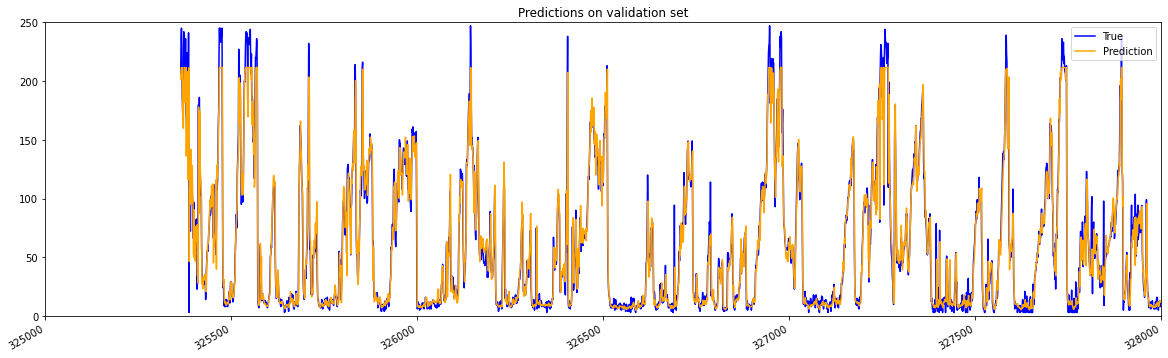

In [27]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(valid.iloc[CFG.seq_length:].index, valid_targets, color='b', label='True')
ax.plot(valid.iloc[CFG.seq_length:].index, valid_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([325000, 328000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()

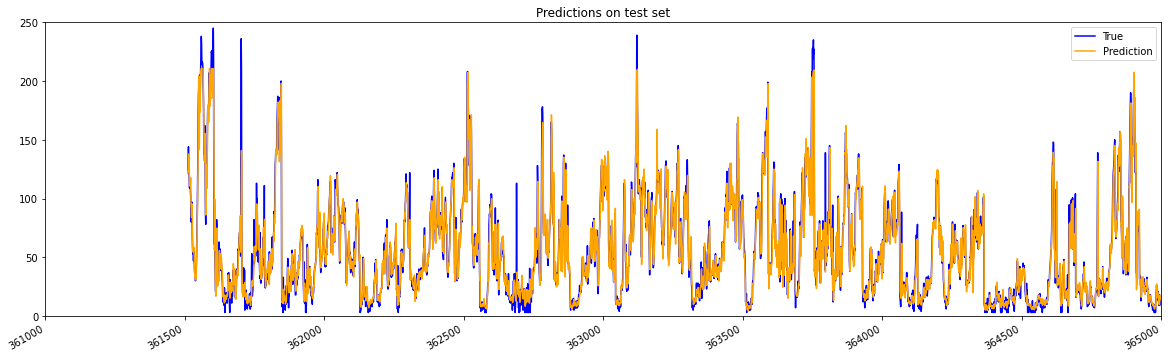

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test.iloc[CFG.seq_length:].index, test_targets, color='b', label='True')
ax.plot(test.iloc[CFG.seq_length:].index, test_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([361000, 365000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on test set')
plt.show()